In [99]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

In [100]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32, 32))])
batch_size = 1
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)


cat_idx = trainset.class_to_idx['airplane']
ship_idx = trainset.class_to_idx['automobile']

n_cat = 500
cat_filtered_indices = []
for i, (_, label) in enumerate(trainset):
    if len(cat_filtered_indices) == n_cat:
        break
    if label == cat_idx:
        cat_filtered_indices.append(i)

n_ship = 500
ship_filtered_indices = []
for i, (_, label) in enumerate(trainset):
    if len(ship_filtered_indices) == n_ship:
        break
    if label == ship_idx:
        ship_filtered_indices.append(i)

filtered_indices = cat_filtered_indices + ship_filtered_indices
print(len(filtered_indices))
new_trainset = torch.utils.data.Subset(trainset, filtered_indices)

trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
1000


In [101]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_cat = 100
cat_filtered_indices = []
for i, (_, label) in enumerate(testset):
    if len(cat_filtered_indices) == n_cat:
        break
    if label == cat_idx:
        cat_filtered_indices.append(i)

n_ship = 100
ship_filtered_indices = []
for i, (_, label) in enumerate(testset):
    if len(ship_filtered_indices) == n_ship:
        break
    if label == ship_idx:
        ship_filtered_indices.append(i)

filtered_indices = cat_filtered_indices + ship_filtered_indices
print(len(filtered_indices))
new_testset = torch.utils.data.Subset(testset, filtered_indices)

testloader = torch.utils.data.DataLoader(new_testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
200


In [102]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0])


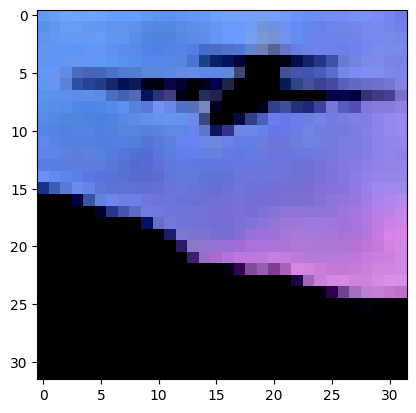

airplane


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [104]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [105]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [106]:
st_time = time.time()
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
            running_loss = 0.0
ed_time = time.time()
print('Finished Training')
print('time taken: ', ed_time - st_time)

[1,   400] loss: 0.691
[1,   800] loss: 0.614
[2,   400] loss: 0.551
[2,   800] loss: 0.449
[3,   400] loss: 0.428
[3,   800] loss: 0.404
[4,   400] loss: 0.374
[4,   800] loss: 0.362
[5,   400] loss: 0.345
[5,   800] loss: 0.302
[6,   400] loss: 0.286
[6,   800] loss: 0.307
[7,   400] loss: 0.219
[7,   800] loss: 0.283
[8,   400] loss: 0.220
[8,   800] loss: 0.264
[9,   400] loss: 0.135
[9,   800] loss: 0.219
Finished Training
time taken:  11.228023529052734


In [107]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 86 %
